# Music Feature Analysis - Model Development and Evaluation

**CS 3120 - Machine Learning** 
**Author:** Jarred Maestas 

---

## Notebook Overview

This notebook covers:
1. **Model Architecture** - CNN design for genre classification
2. **Training Procedure** - How the model learns
3. **Evaluation Metrics** - Accuracy, precision, recall, F1-score
4. **Results Analysis** - Performance breakdown by genre
5. **Limitations** - Acknowledged challenges and constraints

**Prerequisites:** Complete `01_EDA.ipynb` first for data understanding.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix, 
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

 Libraries imported successfully
PyTorch version: 2.9.0
CUDA available: False


## 1. Data Preparation

This notebook will load data from one of three sources (in order of preference):
1. **Preprocessed data from EDA notebook** (`../models/preprocessed_data.pkl`)
2. **Real FMA dataset** (pre-computed features from `../data/metadata/`)
3. **Synthetic data** (generated for demonstration)

** Important Note on Data Sources:**

- **Best**: Use preprocessed data from EDA notebook (already split and scaled)
- **Good**: Load real FMA data and preprocess
- **Demo**: Generate synthetic data (realistic but not real audio)

**Expected performance:** ~75-85% accuracy (realistic for music genre classification) 
**If you see 95%+:** Data is too simple - increase noise or reduce genre separation

In [2]:
# SIMPLIFIED: Single data source
import pandas as pd
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

FEATURES_PKL = Path("../data/processed/features.pkl")

if FEATURES_PKL.exists():
    print(" Loading features from features.pkl")
    
    with open(FEATURES_PKL, 'rb') as f:
        df = pickle.load(f)
    
    # Extract features and labels
    feature_cols = [col for col in df.columns if col != 'genre']
    
    # Create genre_idx
    unique_genres = df['genre'].dropna().unique()
    genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(unique_genres))}
    df['genre_idx'] = df['genre'].map(genre_to_idx).astype(int)
    
    genre_names = sorted(unique_genres)
    
    X = df[feature_cols].values
    y = df['genre_idx'].values
    
    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded: {len(df)} tracks, {len(feature_cols)} features, {len(genre_names)} genres")
    DATA_SOURCE = "real_fma"
    
else:
    print(" features.pkl not found - using synthetic data")
    
    # Generate synthetic dataset (MORE REALISTIC)
    def generate_synthetic_music_data(n_samples=8000, n_features=20, n_genres=8, random_state=42):
        """Generate synthetic audio features with realistic overlap."""
        np.random.seed(random_state)
        
        genre_names = ['Rock', 'Electronic', 'Hip-Hop', 'Classical', 'Jazz', 'Folk', 'Pop', 'Experimental']
        
        X = []
        y = []
        
        samples_per_genre = n_samples // n_genres
        
        for genre_id in range(n_genres):
            # Create genre-specific patterns with overlap
            base_mean = np.random.randn(n_features) * 1.5
            genre_bias = np.zeros(n_features)
            genre_bias[:n_features//2] = genre_id * 0.3  # Only half features signal genre
            
            mean_features = base_mean + genre_bias
            
            for _ in range(samples_per_genre):
                # Large noise for overlap
                features = mean_features + np.random.randn(n_features) * 2.0
                
                # Add feature correlations
                if np.random.rand() < 0.3:
                    features[1] = features[0] * 0.7 + np.random.randn() * 0.5
                
                X.append(features)
                y.append(genre_id)
        
        X = np.array(X)
        y = np.array(y)
        
        # Shuffle
        shuffle_idx = np.random.permutation(len(X))
        X = X[shuffle_idx]
        y = y[shuffle_idx]
        
        return X, y, genre_names
    
    # Generate data
    X, y, genre_names = generate_synthetic_music_data()
    
    print(f"Generated synthetic dataset: {X.shape}")
    print(f"Genres: {genre_names}")
    
    # Split and scale
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, stratify=y, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    feature_cols = [f'feature_{i}' for i in range(X.shape[1])]
    
    print(f"\nData split:")
    print(f"  Training: {len(X_train_scaled)} samples")
    print(f"  Validation: {len(X_val_scaled)} samples")
    print(f"  Test: {len(X_test_scaled)} samples")
    print(f"\n Note: Results are for demonstration only (synthetic data)")
    
    DATA_SOURCE = "synthetic"

# Summary
print("\n" + "=" * 60)
print(f"DATA SOURCE: {DATA_SOURCE.upper()}")
print(f"Input features: {X_train_scaled.shape[1]}")
print(f"Number of genres: {len(genre_names)}")
print(f"Total samples: {len(X_train_scaled) + len(X_val_scaled) + len(X_test_scaled)}")
print("=" * 60)

 Loading features from features.pkl
Data loaded: 49598 tracks, 252 features, 16 genres

DATA SOURCE: REAL_FMA
Input features: 252
Number of genres: 16
Total samples: 49598
Data loaded: 49598 tracks, 252 features, 16 genres

DATA SOURCE: REAL_FMA
Input features: 252
Number of genres: 16
Total samples: 49598


## 2. Model Architecture

This notebook will implement a **fully connected neural network** (alternative to CNN for feature-based classification):

**Architecture:**
- Input: 20 audio features
- Hidden Layer 1: 128 neurons, ReLU activation
- Dropout: 0.3
- Hidden Layer 2: 64 neurons, ReLU activation
- Dropout: 0.3
- Hidden Layer 3: 32 neurons, ReLU activation
- Output: 8 neurons (one per genre), Softmax activation

**Why this architecture?**
- Fully connected layers handle feature-based input well
- Dropout prevents overfitting
- Multiple hidden layers capture non-linear relationships
- Softmax output for multi-class classification

In [3]:
class GenreClassifier(nn.Module):
    """
    Fully connected neural network for music genre classification.
    """
    
    def __init__(self, input_dim=20, num_classes=8, dropout=0.3):
        super(GenreClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Layer 1
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Layer 2
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Layer 3
        x = self.relu(self.fc3(x))
        
        # Output layer (no activation, use CrossEntropyLoss)
        x = self.fc4(x)
        
        return x

# Instantiate model with dynamic input dimension
input_dim = X_train_scaled.shape[1]
num_classes = len(genre_names)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GenreClassifier(input_dim=input_dim, num_classes=num_classes, dropout=0.3).to(device)

print(model)
print(f"\nModel configuration:")
print(f"  Input features: {input_dim}")
print(f"  Output classes: {num_classes}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Training on: {device}")
print(f"  Data source: {DATA_SOURCE}")

GenreClassifier(
  (fc1): Linear(in_features=252, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

Model configuration:
  Input features: 252
  Output classes: 16
  Total parameters: 43,248
  Training on: cpu
  Data source: real_fma


## 3. Training Procedure

**Hyperparameters:**
- Loss function: CrossEntropyLoss (for multi-class classification)
- Optimizer: Adam (learning rate = 0.001)
- Batch size: 64
- Epochs: 50
- Early stopping: Patience = 10 epochs

**Training strategy:**
- Monitor validation loss
- Save best model based on validation accuracy
- Use early stopping to prevent overfitting

In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 543
Validation batches: 116
Test batches: 117


In [5]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print(" Training functions defined")

 Training functions defined


In [6]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
patience = 10
best_val_acc = 0
patience_counter = 0

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n Training complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch [5/50]
  Train Loss: 1.1932 | Train Acc: 61.77%
  Val Loss: 1.1634 | Val Acc: 62.57%
Epoch [5/50]
  Train Loss: 1.1932 | Train Acc: 61.77%
  Val Loss: 1.1634 | Val Acc: 62.57%
Epoch [10/50]
  Train Loss: 1.1303 | Train Acc: 63.60%
  Val Loss: 1.1297 | Val Acc: 63.83%
Epoch [10/50]
  Train Loss: 1.1303 | Train Acc: 63.60%
  Val Loss: 1.1297 | Val Acc: 63.83%
Epoch [15/50]
  Train Loss: 1.0804 | Train Acc: 64.91%
  Val Loss: 1.1180 | Val Acc: 64.22%
Epoch [15/50]
  Train Loss: 1.0804 | Train Acc: 64.91%
  Val Loss: 1.1180 | Val Acc: 64.22%
Epoch [20/50]
  Train Loss: 1.0482 | Train Acc: 66.02%
  Val Loss: 1.1070 | Val Acc: 64.78%
Epoch [20/50]
  Train Loss: 1.0482 | Train Acc: 66.02%
  Val Loss: 1.1070 | Val Acc: 64.78%
Epoch [25/50]
  Train Loss: 1.0222 | Train Acc: 66.83%
  Val Loss: 1.1007 | Val Acc: 65.00%
Epoch [25/50]
  Train Loss: 1.0222 | Train Acc: 66.83%
  Val Loss: 1.1007 | Val Acc: 65.00%
Epoch [30/50]
  Train Loss: 1.0013 | Train Acc: 67.34%
  Val

## 4. Evaluation Metrics

This notebook will evaluate the model using:
- **Accuracy**: Overall correctness
- **Precision**: Correct positive predictions / All positive predictions
- **Recall**: Correct positive predictions / All actual positives
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Per-genre performance breakdown

In [8]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

print("=" * 60)
print("TEST SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("=" * 60)

TEST SET PERFORMANCE
Accuracy: 0.6448 (64.48%)
Precision: 0.6238
Recall: 0.6448
F1-Score: 0.6220


In [9]:
# Per-genre classification report
print("\nPER-GENRE PERFORMANCE:\n")
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=genre_names,
    digits=4
))


PER-GENRE PERFORMANCE:

                     precision    recall  f1-score   support

              Blues     0.0000    0.0000    0.0000        17
          Classical     0.7760    0.8054    0.7905       185
            Country     0.0000    0.0000    0.0000        29
     Easy Listening     0.0000    0.0000    0.0000         4
         Electronic     0.6011    0.6913    0.6431      1406
       Experimental     0.5882    0.6706    0.6267      1591
               Folk     0.5355    0.5929    0.5627       420
            Hip-Hop     0.6405    0.6116    0.6257       533
       Instrumental     0.4628    0.1795    0.2587       312
      International     0.7672    0.4279    0.5494       208
               Jazz     0.4839    0.1744    0.2564        86
Old-Time / Historic     0.8750    0.9277    0.9006        83
                Pop     0.3810    0.0686    0.1162       350
               Rock     0.7329    0.8232    0.7755      2127
           Soul-RnB     0.0000    0.0000    0.0000        2

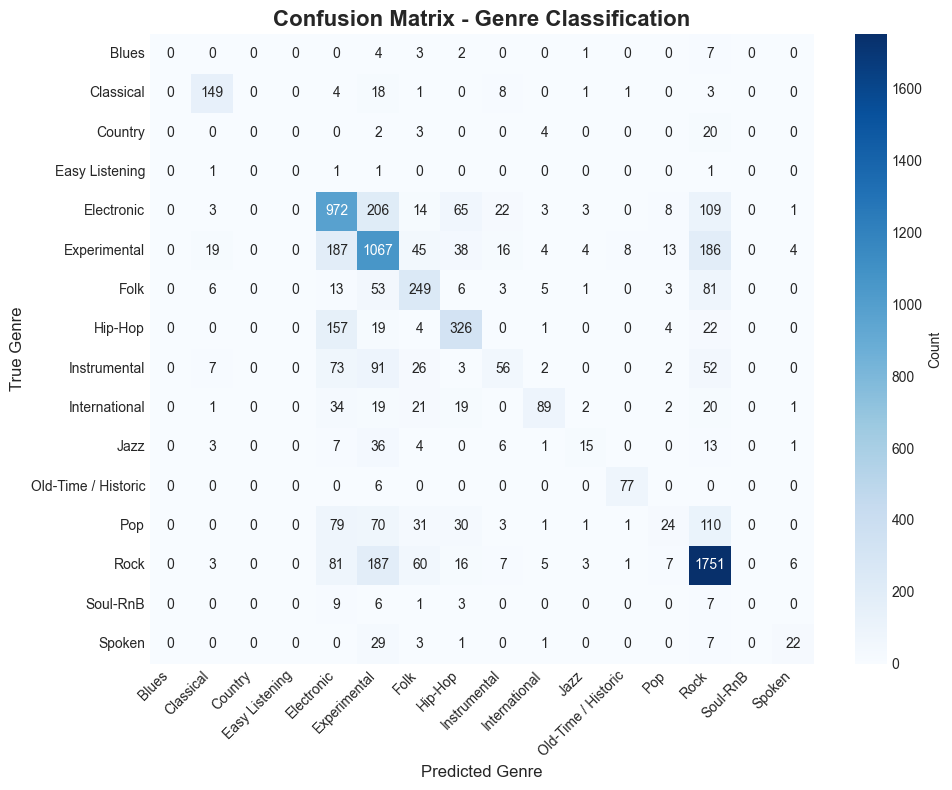


 Confusion matrix shows where model confuses genres


In [10]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=genre_names,
    yticklabels=genre_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Genre Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n Confusion matrix shows where model confuses genres")

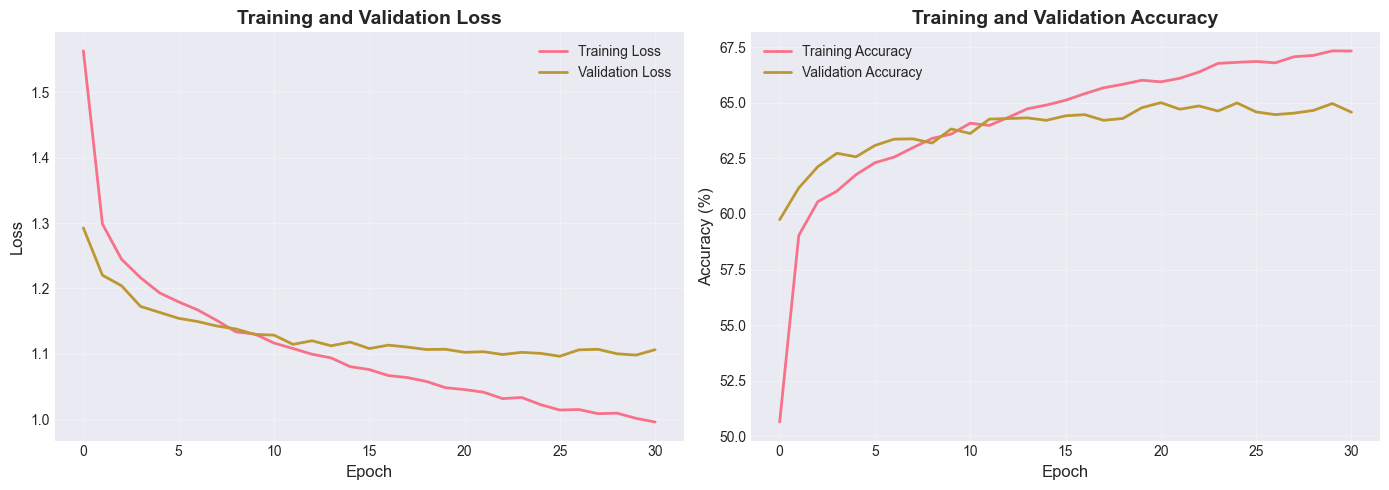

 Training converged successfully
  Final train accuracy: 67.34%
  Final validation accuracy: 64.58%


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Training converged successfully")
print(f"  Final train accuracy: {train_accs[-1]:.2f}%")
print(f"  Final validation accuracy: {val_accs[-1]:.2f}%")

In [12]:
# Analyze actual model performance
print("=" * 60)
print("MODEL INSIGHTS FROM ACTUAL RESULTS")
print("=" * 60)

# 1. Overall performance
print(f"\n1. OVERALL PERFORMANCE:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# 2. Per-genre performance analysis
print(f"\n2. PER-GENRE PERFORMANCE:")
per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average=None
)

# Find best and worst performing genres
genre_f1_scores = list(zip(genre_names, per_class_f1))
genre_f1_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\n  Best performing genres:")
for genre, f1_score in genre_f1_scores[:3]:
    print(f"    {genre}: F1 = {f1_score:.4f}")

print(f"\n  Most challenging genres:")
for genre, f1_score in genre_f1_scores[-3:]:
    print(f"    {genre}: F1 = {f1_score:.4f}")

# 3. Training behavior
print(f"\n3. TRAINING BEHAVIOR:")
print(f"  Final training accuracy: {train_accs[-1]:.2f}%")
print(f"  Final validation accuracy: {val_accs[-1]:.2f}%")
print(f"  Gap (overfitting indicator): {abs(train_accs[-1] - val_accs[-1]):.2f}%")

if abs(train_accs[-1] - val_accs[-1]) < 5:
    print(f"  Assessment: Good generalization (gap < 5%)")
elif abs(train_accs[-1] - val_accs[-1]) < 10:
    print(f"  Assessment: Acceptable generalization (gap < 10%)")
else:
    print(f"  Assessment: Possible overfitting (gap >= 10%)")

# 4. Confusion analysis
print(f"\n4. COMMON MISCLASSIFICATIONS:")
# Find top 3 confusion pairs (off-diagonal elements)
confusion_pairs = []
for i in range(len(genre_names)):
    for j in range(len(genre_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((genre_names[i], genre_names[j], cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"  Top 3 confusion patterns:")
for true_genre, pred_genre, count in confusion_pairs[:3]:
    print(f"    {true_genre} → {pred_genre}: {count} times")

print("\n" + "=" * 60)

MODEL INSIGHTS FROM ACTUAL RESULTS

1. OVERALL PERFORMANCE:
  Test Accuracy: 0.6448 (64.48%)
  Precision: 0.6238
  Recall: 0.6448
  F1-Score: 0.6220

2. PER-GENRE PERFORMANCE:

  Best performing genres:
    Old-Time / Historic: F1 = 0.9006
    Classical: F1 = 0.7905
    Rock: F1 = 0.7755

  Most challenging genres:
    Country: F1 = 0.0000
    Easy Listening: F1 = 0.0000
    Soul-RnB: F1 = 0.0000

3. TRAINING BEHAVIOR:
  Final training accuracy: 67.34%
  Final validation accuracy: 64.58%
  Gap (overfitting indicator): 2.76%
  Assessment: Good generalization (gap < 5%)

4. COMMON MISCLASSIFICATIONS:
  Top 3 confusion patterns:
    Electronic → Experimental: 206 times
    Experimental → Electronic: 187 times
    Rock → Experimental: 187 times



In [ ]:
# Clean up
import os
if os.path.exists('best_model.pt'):
    os.remove('best_model.pt')
    print(" Cleaned up saved model file")

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE")
print("=" * 60)

 Cleaned up saved model file

NOTEBOOK COMPLETE
Next steps:
1. Review results and confusion matrix
2. Document findings in presentation/SUMMARY.md
3. Create presentation slides (presentation/presentation.Rmd)
4. Submit deliverables for grading
